Exploratory analysis

In [1]:
import pandas as pd
import os
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

thedir = os.getcwd()
datadir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/raw'))
writedir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/interim'))
figdir=os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'figures'))
files = os.listdir(datadir)
loggers=len(files)

mylist = []
mycol = []
for i in files:
    mylist.append(pd.read_csv(F"{datadir}/{i}", header = 1))
    mycol.append(i[:7])


In [2]:
#Load files into list of dataframes
mylist = []
mylength = []
for i in files:
    a = pd.read_csv(F"{datadir}/{i}",header =1)
    mylength.append(len(a))
    log = i[:7]
    a = a.iloc[:,[0,1,2]]
    mapping = {a.columns[0]: F"number_{log}", a.columns[1]: F'dt_{log}',a.columns[2]:F"temp_{log}"}
    a.rename(columns=mapping,inplace = True)
    mylist.append(a)
min_length= min(mylength)

## cut all dfs to same size,remove faulty obs of shortest df
newlist = []
for i in mylist:
    newdf = i.iloc[:min_length-4,:]
    newlist.append(newdf)

## concatenate along columns to create new df.
df = pd.concat(newlist,axis = 1)

## extract needed data
cols = ['dt_Log_201']
for i in df.columns:
    if i[:4] == "temp":
        cols.append(i)
temps_ = df[cols].copy()


In [3]:
# convert date time
temps_["time"] = pd.to_datetime(temps_.dt_Log_201,format = '%d/%m/%y %H:%M:%S')
cols[0] = "time"

#extract daily values
temps_["mon_day"] = temps_.time.dt.to_period("d")

# rename columns, get lists for dict use later
old = []
new = []
for i in temps_.columns:
    if i[:4] == "temp":
        log=i[5:]
        old.append(i)
        new.append(log)
newcols = dict(zip(old,new))

<AxesSubplot:xlabel='time', ylabel='temps'>

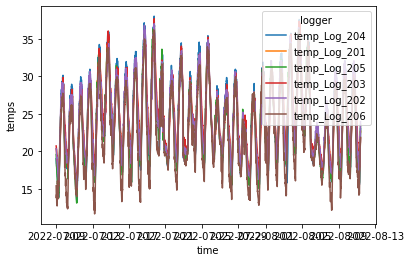

In [4]:
# lineplot of all values
temps = temps_[cols]
temps.to_csv(F"{writedir}/alldata.csv")
#lineplot of all values
temps_m = temps.melt('time', var_name='logger', value_name='temps')
sns.lineplot(data=temps_m, x='time',y='temps',hue = 'logger')

In [5]:
#create dictionaries for use in aggregation
maxl = ["max"]*loggers
minl = ["min"]*loggers
meanl = ["mean"]*loggers
varl = ["var"]*loggers
max_ = dict(zip(new,maxl))
min_ = dict(zip(new,minl))
mean_ = dict(zip(new,meanl))
var_ = dict(zip(new,varl))
temps_.rename(newcols,axis="columns",inplace=True)

In [6]:
# agg by daily values
daily_max = temps_.groupby(["mon_day"]).agg(max_)
daily_min = temps_.groupby(["mon_day"]).agg(min_)
daily_mean = temps_.groupby(["mon_day"]).agg(mean_)
daily_var = temps_.groupby(["mon_day"]).agg(var_)
daily_max.reset_index(inplace=True)
daily_min.reset_index(inplace=True)
daily_mean.reset_index(inplace=True)
daily_var.reset_index(inplace=True)
new.append("mon_day")

In [7]:
dates=["2022-07-10","2022-07-20","2022-07-30","2022-08-09"]
newdates=[]
for i in dates:
    newdates.append(dt.datetime.strptime(i, '%Y-%m-%d').date())

In [8]:
mydata = daily_max[new]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')

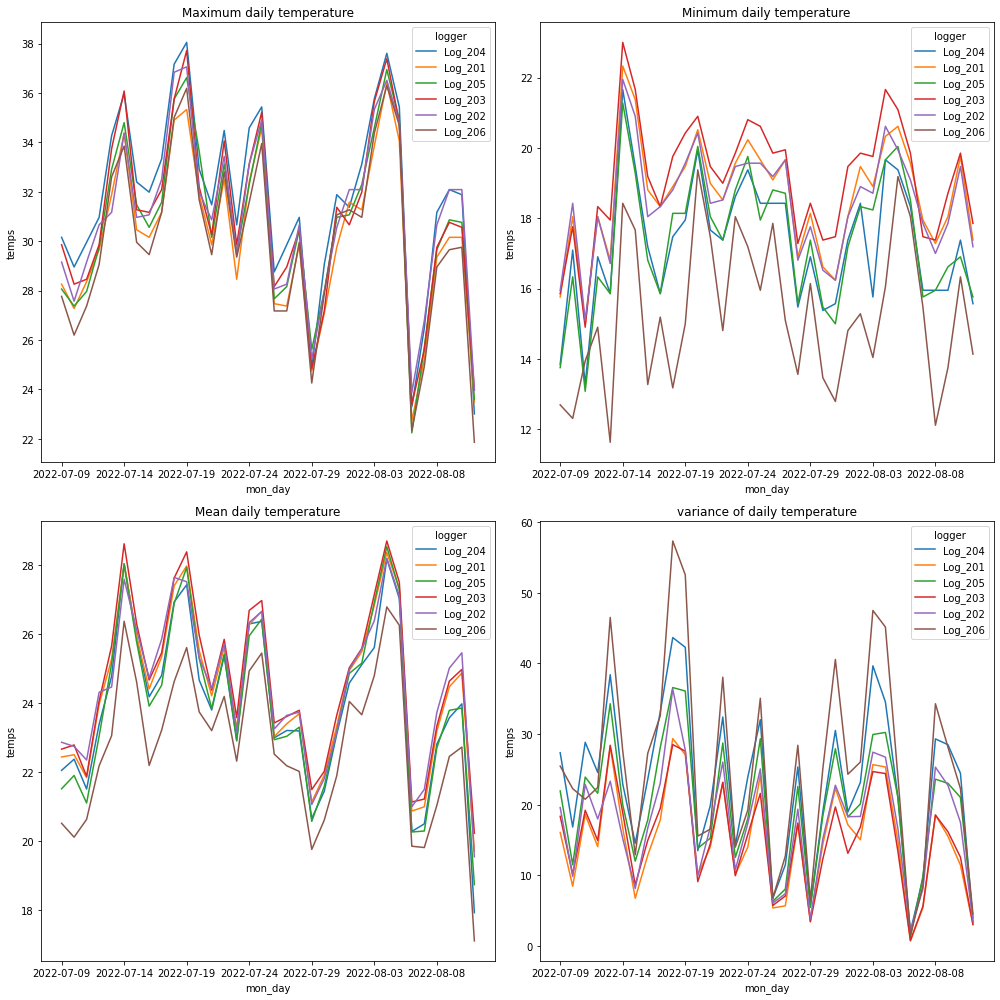

In [11]:
fig, axs = plt.subplots(2,2,figsize=(14,14))
mydata = daily_max[new]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
a=sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax=axs[0,0])
axs[0,0].set_title("Maximum daily temperature")
axs[0,0].xaxis.set_major_locator(ticker.AutoLocator())
mydata = daily_min[new]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax = axs[0,1])
axs[0,1].set_title("Minimum daily temperature")
axs[0,1].xaxis.set_major_locator(ticker.AutoLocator())
mydata = daily_mean[new]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax = axs[1,0])
axs[1,0].set_title("Mean daily temperature")
axs[1,0].xaxis.set_major_locator(ticker.AutoLocator())
mydata = daily_var[new]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax = axs[1,1])
axs[1,1].set_title("variance of daily temperature")
axs[1,1].xaxis.set_major_locator(ticker.AutoLocator())
plt.tight_layout()
plt.savefig(F"{figdir}/summary.png",bbox_inches='tight', dpi = 500)
plt.show()